In [111]:
import gc
print(gc.collect())
import spacy
spacy.load('en')

6


In [112]:
import os
os.chdir('/home/ubuntu/Documents/fastai/old')
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

In [3]:
# !pip install langdetect
# !pip install -U textblob
# !python -m textblob.download_corpora

In [7]:
import fastai
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from fastai.structured import *
from fastai.column_data import *
from fastai.text import *
import html
from textblob import TextBlob, Word
from langdetect import detect

In [3]:
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [6]:
def get_metrics(y_true, y_pred):
    from sklearn.metrics import matthews_corrcoef, accuracy_score, confusion_matrix
    
    print('MCC: ' + str(matthews_corrcoef(y_true, y_pred)))
    print('Accuracy: ' + str(accuracy_score(y_true, y_pred)))
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

In [5]:
path = '/home/ubuntu/Documents/reviews_hackathon_data_Train_test_problem_statement/train/'
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

CLASSES = ['positive', 'negative']
# positive sentiments will be class 0 and negative class 1
# Creating balanced dataset of +ve -ve sentiments. Discarding non-english sentences from train
def get_texts(path):
    texts,labels = [],[]
    other_lang = {}
    unaccounted = 0
    for idx,label in enumerate(CLASSES):
        sz = max(7256, len(eval(label)))
        print(sz)
        for i in tqdm(range(sz)):
            text = json.load(open(f'{path}eng_{label}/{eval(label)[i]}',encoding='utf-8', errors='ignore'))['text']
            try:
                lang = detect(text)
                if(lang == 'en'):
                    texts.append(text)
                    labels.append(idx)
                else:
#                     print(i)
                    if(lang not in other_lang.keys()):
                        other_lang[lang] = 0
                    else:
                        other_lang[lang] += 1
            except:
                unaccounted += 1
                continue
            
    return texts, labels, other_lang, unaccounted

In [10]:
negative = [pos_json for pos_json in os.listdir(f'{path}eng_negative') if pos_json.endswith('.json')]
positive = [pos_json for pos_json in os.listdir(f'{path}eng_positive') if pos_json.endswith('.json')]
print(len(negative), len(positive))

7256 122470


In [11]:
trn_texts,trn_labels, other_lang, unaccounted = get_texts(path)
print(len(trn_texts), len(trn_labels))


In [19]:
print(unaccounted)
print(other_lang)

105
{'da': 1161, 'nl': 983, 'sl': 100, 'ca': 473, 'de': 1785, 'hu': 43, 'fr': 1284, 'pt': 1257, 'it': 1183, 'es': 779, 'af': 532, 'cy': 123, 'vi': 107, 'no': 903, 'fi': 113, 'tl': 96, 'ro': 286, 'sv': 809, 'cs': 21, 'et': 90, 'tr': 19, 'so': 122, 'sw': 11, 'sq': 25, 'hr': 104, 'sk': 29, 'lt': 10, 'id': 95, 'pl': 46, 'lv': 14, 'bg': 0, 'ru': 2, 'he': 0}


In [20]:
# train, val split - stratified
trn, val, trn_labl, val_labl = train_test_split(trn_texts, trn_labels, stratify = trn_labels, test_size = 0.25, random_state = 42)
print(np.unique(trn_labl, return_counts=True), np.unique(val_labl, return_counts=True))

(array([0, 1]), array([82527,  5210])) (array([0, 1]), array([27509,  1737]))


In [21]:
# create df for train, val and save it in a csv. Write the classes in a text file as well
df_trn = pd.DataFrame({'text':trn, 'labels':trn_labl}, columns=['labels', 'text'])
df_val = pd.DataFrame({'text':val, 'labels':val_labl}, columns=['labels', 'text'])
df_trn.to_csv(f'{path}newutf/train_all.csv', header = False, index = False)
df_val.to_csv(f'{path}newutf/validation_all.csv', header = False, index = False)
open(f'{path}/classes.txt', 'w', encoding='utf-8').writelines(f'{o}\n' for o in CLASSES)

print(df_trn.labels.value_counts(), df_val.labels.value_counts())

0    82527
1     5210
Name: labels, dtype: int64 0    27509
1     1737
Name: labels, dtype: int64


In [59]:
# Save the csv files for training language models
lm_trn_texts, lm_val_texts = train_test_split(trn_texts, test_size=0.1)

lm_df_trn = pd.DataFrame({'text':lm_trn_texts, 'labels':[0]*len(lm_trn_texts)}, columns=['labels', 'text'])
lm_df_val = pd.DataFrame({'text':lm_val_texts, 'labels':[0]*len(lm_val_texts)}, columns=['labels', 'text'])

lm_df_trn.to_csv(f'{path}newutf/lm_train_all.csv', header=False, index=False)
lm_df_val.to_csv(f'{path}newutf/lm_validation_all.csv', header=False, index=False)

print(lm_df_trn.shape, lm_df_val.shape)


(105284, 2) (11699, 2)


In [116]:
# Data Cleaning functions
lm_df_t = pd.read_csv(f'{path}newutf/lm_train_all.csv', header=None)
lm_df_t.head()

,0,1
0,0,Excellent support and help for all kind of iss...
1,0,Really happy with my new shades. They are good...
2,0,"Great user experience, was able to check out w..."
3,0,The ease of booking flights was fantastic. The...
4,0,Love Mabel's Labels for school and also got so...


In [117]:
# used to remove all the contractions using apostrophe - standard dictionary available online for classification tasks
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }

# TextBlob package has a spell correct function. Tried working with that, but that was not able to generalize properly. 
# Ideally we wanted to correct just sentiment words, not everything in sentence since there were other parts of speech that didn't matter much.
# Even tried combining word dictionary of vader sentiment with textblob (as in, accept the correction by textblob only if exists in vader word list)
# But the mistakes remained. Hence enumerated spell_check dictionary for most occuring mistakes in test and train data.
spell_check = {'paticence':'patience','curtious':'courteous', 'helpfull':'helpful',':-)':':)', 'thankyou': 'thank you', 'thnx': 'thanks', 'recieved': 'received', 'knowledgable':'knowledgeable', 'alot':'a lot', 'a+':'awesome', 'definately':'definitely', 'recomend':'recommend', 'cashback':'cash back', 'reccomend':'recommend', 'excelent':'excellent', 'topcashback':'top cash back', 'definetly':'definitely', 'awsome':'awesome', 'imazing':'amazing', 'recieve':'receive', 'recommand':'recommend', 'dissapointed':'disappointed', 'accomodating':'accommodating', 'recomended':'recommended', 'correcte': 'corrected', 'aswell':'as well', 'curtious':'courteous', 'reccommend':'recommend', 'exellent':'excellent', 'realy':'really', 'orderd':'ordered', 'excellant': 'excellent', 'lastminute': 'last minute', 'accomodation':'accommodation', 'efficent':'efficient', 'sevice':'service', 'seemless':'seamless', 'delievery':'delivery', 'transcat':'transact', 'effecient':'efficient', 'expierence':'experience', 'seperate':'separate', 'shiping':'shipping', 'pricy':'expensive','recived':'received', 'definitly':'definitely', 'pleasent':'pleasant', 'congrats':'congratulations', 'exelent':'excellent', 'proffesional':'professional', 'excelente':'excellent', 'perfecte':'perfect', 'confortable':'comfortable', 'competetive':'competitive', 'expirience':'experience', 'experince':'experience', 'disapointed':'disappointed', 'immediatly':'immediately', 'experiance':'experience', 'recive':'receive', 'reccomended':'recommended', '5stars': '5 stars', 'resonable':'reasonable', 'accomodate':'accommodate', 'absolutly':'absolutely', 'precios':'precious', 'hastle':'hassle', 'beautifull':'beautiful', 'satified':'satisfied'}

mapping = {**contraction_mapping, **spell_check}

In [118]:
# Cleaning
## Separating words about punctuation (without disturbing urls of form 'abc.com')
## mapping to take care of typos - just for most occuring sentiment words
## Removing multi punctuations/space with regex
## Splitting CamelCase

re4 = re.compile(r'([?. !,+])\1+')
re1 = re.compile(r'  +')
def fixup(x):
    # replacing funny chars
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ').replace('\r\n',"\n")
    x = re4.sub(r'\1', html.unescape(x))
    x = x.replace('.','. ').replace('. com', '.com').replace(',',', ').replace('?','? ').replace('!','! ')
    x = re1.sub(' ', x)
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        x = x.replace(s, "'")
    # Also separating camel case instances in the else condition
    x = ' '.join([mapping[t.lower()] if t.lower() in mapping else ' '.join(re.findall(r'[A-Z][^A-Z]+', t)) if re.match(r'[A-Z][^A-Z]+', t) else t for t in x.split(" ")])
    return x

In [119]:
# Fastai tokenizer
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = list(texts.apply(fixup).values)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [16]:
# lm_df_trn = pd.read_csv(f'{path}newutf/lm_train_all.csv', header=None)
# lm_df_val = pd.read_csv(f'{path}newutf/lm_validation_all.csv', header=None)

# # Few extra row drops as n when noticed
# lm_df_trn.drop(index = [63], inplace = True)
# lm_df_trn.reset_index(drop=True, inplace=True)
# lm_df_trn.to_csv(f'{path}newutf/lm_train_all.csv', header=False, index=False)

In [187]:
chsz = 25000
lm_df_trn = pd.read_csv(f'{path}newutf/lm_train_all.csv', header=None, chunksize = chsz)
lm_df_val = pd.read_csv(f'{path}newutf/lm_validation_all.csv', header=None, chunksize = chsz)

In [121]:
tok_trn, trn_labels = get_all(lm_df_trn, 1)
tok_val, val_labels = get_all(lm_df_val, 1)


0
1
2
3
4
0


In [128]:
tok_val

[['\n',
  'xbos',
  'xfld',
  '1',
  'exactly',
  'the',
  'appliance',
  'advised',
  'by',
  'physiotherapist',
  '.',
  'easily',
  'ordered',
  'on',
  'line',
  'and',
  'dispatched',
  'within',
  'hours',
  '.',
  'delivered',
  'next',
  'day',
  'even',
  'though',
  'i',
  'only',
  'paid',
  'for',
  'standard',
  'delivery',
  '.',
  'excellent',
  'service',
  '.',
  'thank',
  'you',
  '.'],
 ['\n',
  'xbos',
  'xfld',
  '1',
  'i',
  'am',
  'working',
  'with',
  'this',
  'company',
  'since',
  'about',
  '2',
  'month',
  '.',
  '\n',
  'so',
  'far',
  'i',
  'have',
  'invested',
  'a',
  'high',
  '6',
  'digit',
  '$',
  'amount',
  '.',
  '\n',
  'i',
  'am',
  'extremely',
  'satisfied',
  'with',
  'this',
  'company',
  '.',
  '\n',
  'i',
  'am',
  'going',
  'to',
  'enlarge',
  'my',
  'investments',
  'with',
  'this',
  'trustful',
  'corporation',
  '.'],
 ['\n',
  'xbos',
  'xfld',
  '1',
  'love',
  'love',
  'love',
  'the',
  'selection',
  'of',
  

In [19]:
np.save(f'{path}newutf/tmp/tok_trn.npy', tok_trn)
np.save(f'{path}newutf/tmp/tok_val.npy', tok_val)

In [20]:
tok_trn = np.load(f'{path}newutf/tmp/tok_trn.npy')
tok_val = np.load(f'{path}newutf/tmp/tok_val.npy')

In [21]:
tok_trn[:5]

array([list(['\n', 'xbos', 'xfld', '1', 'excellent', 'support', 'and', 'help', 'for', 'all', 'kind', 'of', 'issues', '.', 'i', 'highly', 'recommend', 'template', 'monster', '!', 'buying', 'template', 'from', 'template', 'monster', 'you', 'get', 'much', 'more', 'than', 'expected', '!']),
       list(['\n', 'xbos', 'xfld', '1', 'really', 'happy', 'with', 'my', 'new', 'shades', '.', 'they', 'are', 'good', 'quality', 'and', 'arrived', 'promptly', 'and', 'well', 'packed', '.', 'look', 'stunning', 'in', 'my', 'lounge', '!']),
       list(['\n', 'xbos', 'xfld', '1', 'great', 'user', 'experience', ',', 'was', 'able', 'to', 'check', 'out', 'without', 'any', 'problems', '!']),
       list(['\n', 'xbos', 'xfld', '1', 'the', 'ease', 'of', 'booking', 'flights', 'was', 'fantastic', '.', 'the', 'prices', 'were', 'excellent', 'and', 'the', 'flexible', 'date', 'calendar', 'was', 'very', 'helpful', '.']),
       list(['\n', 'xbos', 'xfld', '1', 'love', 'mabel', "'s", 'labels', 'for', 'school', 'and', 'a

In [22]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

[('.', 218423),
 ('the', 140662),
 ('and', 131581),
 ('\n', 130937),
 ('i', 123045),
 ('1', 106949),
 ('xbos', 105283),
 ('xfld', 105283),
 ('to', 101157),
 (',', 92564),
 ('a', 70710),
 ('was', 58539),
 ('my', 45726),
 ('for', 42384),
 ('of', 40633),
 ('it', 38368),
 ('with', 38104),
 ('!', 36919),
 ('in', 35914),
 ('is', 34587),
 ('have', 32657),
 ('very', 31902),
 ('not', 30789),
 ('t_up', 30710),
 ('they', 26958)]

In [23]:
len(freq.items())

48388

In [24]:
freq.elements

<bound method Counter.elements of Counter({'.': 218423, 'the': 140662, 'and': 131581, '\n': 130937, 'i': 123045, '1': 106949, 'xbos': 105283, 'xfld': 105283, 'to': 101157, ',': 92564, 'a': 70710, 'was': 58539, 'my': 45726, 'for': 42384, 'of': 40633, 'it': 38368, 'with': 38104, '!': 36919, 'in': 35914, 'is': 34587, 'have': 32657, 'very': 31902, 'not': 30789, 't_up': 30710, 'they': 26958, 'service': 26312, 'great': 25722, 'on': 25624, 'that': 24964, 'you': 23322, 'this': 21090, 'me': 18099, 'easy': 18005, 'from': 17943, 'good': 17628, 'had': 17421, 'as': 16328, 'would': 16082, 'we': 16058, 'are': 15805, 'so': 15246, 'will': 15027, 'but': 14561, 'time': 14490, 'all': 14409, 'at': 13884, 'be': 13809, 'them': 13345, 'were': 13261, 'order': 12431, '-': 11316, 'no': 11165, 'fast': 10700, 'delivery': 10615, 'use': 10581, 'recommend': 9986, 'when': 9913, 'price': 9816, 'again': 9792, 'customer': 9722, 'an': 9656, 'am': 9334, 'been': 9014, 'do': 8895, 'what': 8848, 'excellent': 8813, 'up': 8607,

In [25]:
max_vocab = 60000
min_freq = 2

In [26]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

In [27]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

18327

In [82]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])
np.save(f'{path}newutf/tmp/trn_ids.npy', trn_lm)
np.save(f'{path}newutf/tmp/val_ids.npy', val_lm)
pickle.dump(itos, open(f'{path}newutf/tmp/itos.pkl', 'wb'))

In [83]:
len(itos), len(trn_lm)

(18327, 10420)

In [30]:
# ! wget -nH -r -np -P {path} http://files.fast.ai/models/wt103/

## ULMFiT

In [31]:
# Just as fwd_wt103, there is bwd_wt103 pretrained model. Entire training exercise can be repeated for that as well.
# Final result submitted was ensemble of both these.

em_sz,nh,nl = 400,1150,3
PRE_PATH = f'{path}models/wt103/'
PRE_LM_PATH = f'{PRE_PATH}fwd_wt103.h5'

In [32]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

In [33]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [34]:
itos2 = pickle.load(open(f'{PRE_PATH}itos_wt103.pkl','rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

In [35]:
not_found = []
new_w = np.zeros((len(itos), em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    if r >= 0:
        new_w[i] = enc_wgts[r]
    else:
        new_w[i] = row_m
        not_found += [w]
        print(w, freq[w])

:) 1184
flighthub 626
ssense 435
banggood 429
fabletics 401
👍 341
redspot 226
goldcar 224
housesitters 214
flashbay 196
thriftbooks 185
lyft 183
😊 180
rentalcars.com 153
servcorp 150
biblio 150
dhgate 149
'm 141
airtasker 139
ofx 133
've 133
amoma 130
otticanet 124
tomtop 123
jomashop 111
️ 111
nfm 107
trustpilot 106
bravofly 101
ezcater 98
rentalcars 95
goway 95
vape 95
agoda 94
payed 94
bbg 93
vacay 87
homeadvisor 86
😀 86
🏻 77
opti 72
❤ 72
optimalprint 69
;) 68
travelgenio 68
snus 67
thankyou 67
inkfarm 63
transferwise 61
oldies.com 61
euroflorist 60
pickleball 59
inkstation 59
yesstyle 57
strawberrynet 56
gaggia 56
intoxalock 54
⭐ 54
👌 53
spotahome 53
pond5 52
purolator 52
micks 51
firmoo 51
matboard 50
knowledgable 50
taxibox 50
😁 49
hoselink 49
uttings 48
24hrs 47
lastminute.com 47
ltb 47
biblio.com 47
a+ 46
verc 46
blinds2go 46
foodler 46
booking.com 45
resend 44
apmex 44
:( 44
munchery 44
sellbackyourbook.com 43
promgirl 42
edreams 41
zodee 41
amiclubwear 40
wts 39
opticontacts 

000k 4
yotaphone 4
spammed 4
avaliable 4
viagogo 4
modelsport 4
willisorchards.com 4
sr22 4
decribed 4
shippings 4
mahalo 4
keepcalling 4
congierge 4
1-way 4
dealed 4
whith 4
immediatly 4
euless 4
interparcel 4
fingerhut 4
cruisefinder 4
🚗 4
decolar 4
preços 4
recomendo 4
housesitters.com 4
veloce 4
articoli 4
:o) 4
😜 4
sth 4
anyones 4
buoni 4
itenerary 4
did'nt 4
comox 4
oponeo 4
recommned 4
customerservice 4
ricossa 4
allbeauty.com 4
producto 4
touriocity 4
dogsitter 4
accor 4
ushuaia 4
incontinent 4
successfull 4
suport 4
🙃 4
2yrs 4
marcaria 4
sended 4
hardbacks 4
cheeper 4
throught 4
currencyonline 4
teknikdelar 4
powerstroke 4
popups 4
biofinity 4
years- 4
rounded.com 4
s&h 4
usedlighting.com 4
macs4 4
goldcars 4
dianhua 4
20k 4
4:30 4
cashstop 4
faqs 4
hydroflask 4
stayclassy 4
itinery 4
scuff 4
beddingstyle 4
d3boost 4
vetapprovedrx 4
flashdrives 4
geat 4
icelolly 4
experince 4
tyresonthe 4
annalin 4
stockists 4
intl 4
jpg 4
allready 4
dind't 4
dris 4
-no 4
yhe 4
sahul 4
newish 

In [36]:
len(not_found)

2377

In [37]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

In [38]:
wd=1e-7
bptt=70
bs=52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [39]:
# Training language model
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(f'{path}', 1, len(itos), trn_dl, val_dl, bs=bs, bptt=bptt)
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

In [40]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

In [41]:
learner.model.load_state_dict(wgts)
lr=1e-3
lrs = lr

In [237]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)


  0%|          | 0/1186 [00:00<?, ?it/s]

epoch      trn_loss   val_loss   accuracy                       
    0      4.412621   4.184552   0.280464  


[array([4.18455]), 0.28046438406167373]

In [239]:
learner.save('lm_last_ft')

In [42]:
learner.load('lm_last_ft')
learner.unfreeze()
# learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)
# learner.sched.plot()

In [43]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)

epoch      trn_loss   val_loss   accuracy                        
    0      3.79016    3.577099   0.34032   
    1      3.56681    3.425028   0.353395                        
    2      3.42135    3.360999   0.359805                        
 22%|██▏       | 262/1186 [24:53<1:18:12,  5.08s/it, loss=3.39]

KeyboardInterrupt: 

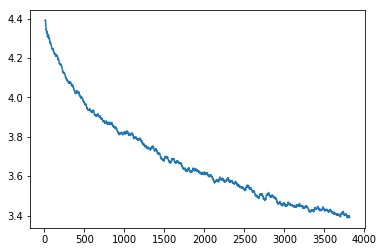

In [44]:
learner.save('lm1')
learner.save_encoder('lm1_enc')
learner.sched.plot_loss()

In [73]:
df_trn = pd.read_csv(f'{path}newutf/train_all.csv', header=None)
df_val = pd.read_csv(f'{path}newutf/validation_all.csv', header=None)

In [74]:
# df_trn_neg = df_trn[df_trn[0] == 1]
# print(df_trn_neg.shape)
# df_val_neg = df_val[df_val[0] == 1]
# df_val_neg.shape

(5210, 2)


(1737, 2)

In [75]:
# # Create a balanced set
# df_trn_pos = df_trn[df_trn[0] == 0].sample(n = df_trn_neg.shape[0], random_state = 42)
# df_trn_f = pd.concat([df_trn_neg, df_trn_pos])
# df_trn_f = df_trn_f.sample(frac = 1)
# print(df_trn_f.shape)

# df_val_pos = df_val[df_val[0] == 0].sample(n = df_val_neg.shape[0], random_state = 42)
# df_val_f = pd.concat([df_val_neg, df_val_pos])
# df_val_f = df_val_f.sample(frac = 1)
# df_val_f.shape

(10420, 2)


(3474, 2)

In [6]:
# df_trn_f.to_csv(f'{path}train_downsample.csv', header=False, index = False)
# df_val_f.to_csv(f'{path}validation_downsample.csv', header=False, index = False)
df_trn_final = pd.read_csv(f'{path}train_downsample.csv', header=None)
df_trn_final.head()

,0,1
0,0,AMR is my new go to for anything hair and beau...
1,1,"Asked sales rep to confirm details of booking,..."
2,0,The items I have bought are as they have been ...
3,0,It was really simple to transfer GBP to EUR an...
4,0,keith was very knowledgeable and calm i would ...


In [8]:
df_trn_final = pd.read_csv(f'{path}train_downsample.csv', header=None, chunksize = 2000)
df_val_final = pd.read_csv(f'{path}validation_downsample.csv', header=None, chunksize = 2000)

In [8]:
# tok_trn, trn_labels = get_all(df_trn_final, 1)
# tok_val, val_labels = get_all(df_val_final, 1)

In [85]:
# np.save(f'{path}newutf/tmp/tok_trn_c.npy', tok_trn)
# np.save(f'{path}newutf/tmp/tok_val_c.npy', tok_val)

# np.save(f'{path}newutf/tmp/trn_labels.npy', trn_labels)
# np.save(f'{path}newutf/tmp/val_labels.npy', val_labels)

In [201]:
tok_trn = np.load(f'{path}newutf/tmp/tok_trn_c.npy')
tok_val = np.load(f'{path}newutf/tmp/tok_val_c.npy')

In [202]:
tok_trn

array([list(['\n', 'xbos', 'xfld', '1', 't_up', 'amr', 'is', 'my', 'new', 'go', 'to', 'for', 'anything', 'hair', 'and', 'beauty', '.', '\n', 'i', 'highly', 'recommend', '!']),
       list(['\n', 'xbos', 'xfld', '1', 'asked', 'sales', 'rep', 'to', 'confirm', 'details', 'of', 'booking', ',', 'these', 'were', 'incorrect', '.', 'asked', 'him', 'to', 'cancel', 'booking', ',', 'stated', 'that', 'it', 'had', 'been', 'processed', 'although', 'we', 'had', 'not', 'authorised', 'it', '!', '\n', 'he', 'hung', 'up', 'and', 'transferred', 'us', 'to', 'the', 'switch', 'board', '.', 'we', 'got', 'through', 'to', 'a', 'customer', 'service', 'rep', ',', 'provided', 'him', 'with', 'the', 'details', 'that', 'we', 'booked', 'with', 'and', 'he', 'states', 'that', 'there', 'is', 'no', 'record', 'of', 'any', 'booking', '.', '\n', 'i', 'called', 'my', 'bank', 'and', 'we', 't_up', 'have', 't_up', 'been', 't_up', 'charged', '!', '\n', 'i', 'am', 'outraged', '.']),
       list(['\n', 'xbos', 'xfld', '1', 'the', '

In [229]:
itos = pickle.load(open(f'{path}newutf/tmp/itos.pkl','rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

18327

In [15]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

In [92]:
np.save(f'{path}newutf/tmp/trn_ids_c.npy', trn_clas)
np.save(f'{path}newutf/tmp/val_ids_c.npy', val_clas)

In [16]:
trn_clas = np.load(f'{path}newutf/tmp/trn_ids_c.npy')
val_clas = np.load(f'{path}newutf/tmp/val_ids_c.npy')

In [406]:
trn_labels = np.squeeze(np.load(f'{path}newutf/tmp/trn_labels.npy'))
val_labels = np.squeeze(np.load(f'{path}newutf/tmp/val_labels.npy'))
# trn_labels = np.squeeze(trn_labels)
# val_labels = np.squeeze(val_labels)

In [407]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 48

In [408]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In [409]:
# test_labels_dummy  = np.squeeze(test_labels_dummy)
test_labels_dummy


array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [412]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
# test_ds = TextDataset(test_clas, test_labels_dummy)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
test_samp = SortSampler(test_clas, key=lambda x: len(test_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
# test_dl = DataLoader(test_ds, bs, transpose=True, num_workers=1, pad_idx=1)
md = ModelData(f'{path}', trn_dl, val_dl)

In [413]:
dps = np.array([0.4, 0.5, 0.05, 0.3, 0.1])

In [414]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.5

In [415]:
# Training classification model
m = get_rnn_classifier(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [416]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [417]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=.25
learn.metrics = [accuracy]

In [418]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [419]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [420]:
wd = 1e-7
wd = 0
learn.load_encoder('lm1_enc')

In [335]:
learn.freeze_to(-1)

In [375]:
# learn.lr_find(lrs/1000)
# learn.sched.plot()

In [107]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                    
    0      0.372357   0.173148   0.936385  


[array([0.17315]), 0.936384571099597]

In [108]:
learn.save('clas_0')

In [115]:
learn.freeze_to(-2)

In [116]:
learn.fit(lrs, 1, wds=wd, cycle_len=2, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                    
    0      0.370382   0.187916   0.936672  
    1      0.254873   0.154386   0.943293                    


[array([0.15439]), 0.9432930339666091]

In [117]:
learn.save('clas_1')

In [ ]:
learn.unfreeze()
learn.fit(lrs, 1, wds=wd, cycle_len=11, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy                      
    0      0.31802    0.194199   0.941566  
    1      0.227685   0.218674   0.943005                      
 33%|███▎      | 145/435 [14:17<28:40,  5.93s/it, loss=0.227] 

In [ ]:
learn.save('clas_2_3_epoch_cleaner')

In [421]:
learn.load('clas_1')

In [99]:
y,y_true = learn.predict_with_targs()

In [104]:
y_pred = np.argmax(y, axis =1) 

In [63]:
get_metrics(y_pred,y_true)

MCC: 0.9090873849327937
Accuracy: 0.9545192861255037
[[1649   70]
 [  88 1667]]


In [ ]:
# Vader sentiment just to get a baseline and explore results (& possible ensemble strategies)
df_trn = pd.read_csv(f'{path}newutf/train_all.csv', header=None)
df_val = pd.read_csv(f'{path}newutf/validation_all.csv', header=None)
# print(df_trn[0].value_counts(), df_val[0].value_counts())

RE_EMOJI = re.compile(r'([\U00010000-\U0010ffff])', flags=re.UNICODE)
def spellfix(x):
    # replacing funny chars
    re4 = re.compile(r'([. ,+])\1+')
    re1 = re.compile(r'  +')
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ').replace('\r\n',"\n")
    x = re4.sub(r'\1', html.unescape(x))
    x = x.replace('.','. ').replace('. com', '.com').replace(',',', ')
    x = RE_EMOJI.sub(r' \1 ', x)
    x = re1.sub(' ', x)
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        x = x.replace(s, "'")
    # Also separating camel case instances in the else condition
    x = ' '.join([spell_check[t.lower()] if t.lower() in spell_check else ' '.join(re.findall(r'[A-Z][^A-Z]+', t)) if re.match(r'[A-Z][^A-Z]+', t) else t for t in x.split(" ")])
    return x

def clean_to_df(df, col, c=0):
    if c == 0:
        return df
    elif c == 1:
        df[col] = df[col].apply(spellfix)
    else:
        df[col] = df[col].apply(fixup)
    return df

# Vader
# !pip install vaderSentiment
clean_level = 1
df_val_cleaned = clean_to_df(df_val, 1, clean_level)
importlib.reload(vaderSentiment.vaderSentiment)
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer, SentiText
analyser = SentimentIntensityAnalyzer()
def sentiment_analyzer_scores_1(sentence):
    score = analyser.polarity_scores(sentence)
    if(score['pos'] >= score['neg']):
        return 0
    else:
        return 1
def sentiment_analyzer_scores_2(sentence):
    score = analyser.polarity_scores(sentence)
    if(score['compound'] <= -0.05):
        return 1
    else:
        return 0
    
def single_eg_analyse(sentence):
    score = analyser.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(score)))

df_val_cleaned['prediction'] = df_val_cleaned[1].apply(sentiment_analyzer_scores_2)

df_val_cleaned.head()

In [267]:
get_metrics(df_val_cleaned[0].values, df_val_cleaned['prediction'].values)

MCC: 0.5099024154738517
Accuracy: 0.9446761950352185
[[26681   828]
 [  790   947]]


Test data processing and scoring

In [ ]:
# Test data load
converted_texts, converted_filenames = [],[]
def get_test_data():
    test_path = 'C:\\Users\\CAG04\\SL\\Fractal_hackathon\\T2\\reviews_hackathon_data_Train_test_problem_statement\\test\\'
    texts = []
    other_lang = {}
    unaccounted,other_lang_fs,filenames = [],[],[]
    test_files = [pos_json for pos_json in os.listdir(f'{test_path}') if pos_json.endswith('.json')]
    sz = len(test_files)
    print(sz)
    for i in tqdm(range(sz)):
        text = json.load(open(f'{test_path}{test_files[i]}',encoding='utf-8', errors='ignore'))['text']
        try:
            lang = detect(text)
            if(lang == 'en'):
                texts.append(text)
                filenames.append(test_files[i])
            else:
                if(lang not in other_lang.keys()):
                    other_lang[lang] = 0
                else:
                    other_lang[lang] += 1
                other_lang_fs += [test_files[i]]
        except:
            unaccounted += [test_files[i]]
            continue
    return texts, filenames, unaccounted, other_lang_fs, other_lang

# Converting the non english reviews in test to english using google API (textblob uses that internally)
# Google API has restrictions on number of translation per IP.
def get_other_lang_text(other_lang_files):
    for f in other_lang_files:
        text = json.load(open(f'{test_path}{f}',encoding='utf-8', errors='ignore'))['text']
        b = TextBlob(text)
        converted = b.translate(to='en')
        converted_text.append(converted)
        converted_filenames.append(f)

In [ ]:
test_data, filenames, unaccounted, other_lang_files, other_lang = get_test_data()

In [192]:
print(len(test_data), len(filenames), len(unaccounted), len(other_lang_files))

3325 3325 3 317


In [193]:
# This file contains the converted text
test_df_other_langs = pd.read_csv('/home/ubuntu/Documents/foreign_lang_text.csv')
test_df_other_langs.shape

(317, 2)

In [200]:
test_df_en = pd.DataFrame({'Filename':filenames,'Text':test_data})
print(test_df_en.shape)
test_df = pd.concat([test_df_en, test_df_other_langs])
print(test_df.shape)
test_df.head()

(3325, 2)
(3642, 2)


,Filename,Text
0,0010e1c711e659b49024ede29074848a.json,FiOS is the best an internet and television.
1,00186ce92dc10278e3f9cb3836843dbb.json,Agent answered all questions in a clear and un...
2,003b5092931802475483377091d44169.json,Use another shipper?
3,003b90e0a6146683b93f8d8def64fed9.json,"I purchased an expensive TV from Groupon--$1,3..."
4,003fd43b174abef8823a1c8ab392dec2.json,I received a Quote: to sell this book multiple...


In [ ]:
for i in unaccounted:
    test_df.loc[test_df.shape[0]] = [i,json.load(open(f'{test_path}{i}',encoding='utf-8', errors='ignore'))['text']]

In [ ]:
test_df.to_csv('/home/ubuntu/Documents/test_df.csv', index=False)

In [263]:
#Test data scoring
test_df_g = pd.read_csv('/home/ubuntu/Documents/test_df.csv')
test_df_g.head()

,Filename,Text
0,0010e1c711e659b49024ede29074848a.json,FiOS is the best an internet and television.
1,00186ce92dc10278e3f9cb3836843dbb.json,Agent answered all questions in a clear and un...
2,003b5092931802475483377091d44169.json,Use another shipper?
3,003b90e0a6146683b93f8d8def64fed9.json,"I purchased an expensive TV from Groupon--$1,3..."
4,003fd43b174abef8823a1c8ab392dec2.json,I received a Quote: to sell this book multiple...


In [264]:
test_df_g.shape

(3645, 2)

In [265]:
contraction_mapping_test = {"ain't": "is not", "aren't": "are not","can't": "cannot", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }
spell_check_test = {'responsable':'responsible','difficultly':'difficulty', 'responsability':'responsibility', 'insted':'instead', 'paticence':'patience','curtious':'courteous', 'helpfull':'helpful',':-)':':)', 'thankyou': 'thank you', 'thnx': 'thanks', 'recieved': 'received', 'knowledgable':'knowledgeable', 'alot':'a lot', 'a+':'awesome', 'definately':'definitely', 'recomend':'recommend', 'cashback':'cash back', 'reccomend':'recommend', 'excelent':'excellent', 'topcashback':'top cash back', 'definetly':'definitely', 'awsome':'awesome', 'imazing':'amazing', 'recieve':'receive', 'recommand':'recommend', 'dissapointed':'disappointed', 'accomodating':'accommodating', 'recomended':'recommended', 'correcte': 'corrected', 'aswell':'as well', 'curtious':'courteous', 'reccommend':'recommend', 'exellent':'excellent', 'realy':'really', 'orderd':'ordered', 'excellant': 'excellent', 'lastminute': 'last minute', 'accomodation':'accommodation', 'efficent':'efficient', 'sevice':'service', 'seemless':'seamless', 'delievery':'delivery', 'transcat':'transact', 'effecient':'efficient', 'expierence':'experience', 'seperate':'separate', 'shiping':'shipping', 'pricy':'expensive','recived':'received', 'definitly':'definitely', 'pleasent':'pleasant', 'congrats':'congratulations', 'exelent':'excellent', 'proffesional':'professional', 'excelente':'excellent', 'perfecte':'perfect', 'confortable':'comfortable', 'competetive':'competitive', 'expirience':'experience', 'experince':'experience', 'disapointed':'disappointed', 'immediatly':'immediately', 'experiance':'experience', 'recive':'receive', 'reccomended':'recommended', '5stars': '5 stars', 'resonable':'reasonable', 'accomodate':'accommodate', 'absolutly':'absolutely', 'precios':'precious', 'hastle':'hassle', 'beautifull':'beautiful', 'satified':'satisfied'}

mapping_test = {**contraction_mapping_test, **spell_check_test}

In [266]:
# Same cleaning as train
re4 = re.compile(r'([?. !,+])\1+')
re1 = re.compile(r'  +')
def fixup_test(x):
    # replacing funny chars
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ').replace('\r\n',"\n")
    x = re4.sub(r'\1', html.unescape(x))
    x = x.replace('.','. ').replace('. com', '.com').replace(',',', ').replace('?','? ').replace('!','! ')
    x = re1.sub(' ', x)
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        x = x.replace(s, "'")
    # Also separating camel case instances in the else condition
    x = ' '.join([mapping_test[t.lower()] if t.lower() in mapping_test else ' '.join(re.findall(r'[A-Z][^A-Z]+', t)) if re.match(r'[A-Z][^A-Z]+', t) else t for t in x.split(" ")])
    return x

def get_all_test(df):
    texts = f'\n{BOS} {FLD} 1 ' + df['Text'].astype(str)
    texts = list(texts.apply(fixup_test).values)
    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok

In [274]:
tok_test = get_all_test(test_df_g)
filenames = test_df_g['Filename'].values

In [300]:
filenames_dict = {}
c = 0
for i in filenames:
    filenames_dict[i] = c
    c += 1

In [301]:
filenames_map = [filenames_dict[i] for i in filenames]

In [304]:
filenames_map=np.array(filenames_map)

In [275]:
freq = Counter(p for o in tok_test for p in o)
# freq.most_common(25)

In [276]:
len(freq.keys())

10270

In [277]:
# ones not in vocab
unacc = 0
for i in freq.most_common(19831):
    if(stoi[i[0]] == 0):
        unacc += 1
        print(i[0], '----', freq[i[0]])
        

leiden ---- 18
kon ---- 8
pep ---- 7
aaverix ---- 7
breach ---- 6
quinton ---- 6
corbin ---- 5
hostelworld ---- 4
haircut ---- 4
dancard ---- 4
probe ---- 4
j'ai ---- 4
braclet ---- 4
beams ---- 4
ontrac ---- 4
querying ---- 4
telephoning ---- 4
liftopia ---- 4
terminated ---- 4
reissue ---- 4
pharmapacks ---- 4
wan't ---- 4
servicingstop ---- 4
modecor ---- 4
saigon ---- 4
thiefs ---- 3
multimeter ---- 3
caddy ---- 3
sacked ---- 3
fsmail ---- 3
hyphenated ---- 3
hippo ---- 3
greenmotion ---- 3
avec ---- 3
prepaying ---- 3
sct ---- 3
149 ---- 3
2v ---- 3
buick ---- 3
busbud ---- 3
appartement ---- 3
internally ---- 3
fences ---- 3
113 ---- 3
kr ---- 3
saler ---- 3
customstax ---- 3
tyers ---- 3
vroom ---- 3
tu ---- 3
luego ---- 3
tienes ---- 3
bodyphone ---- 3
shouted ---- 3
bravofly.com ---- 3
visconti ---- 3
kv ---- 3
cet ---- 3
feared ---- 3
jeg ---- 3
windjammer ---- 3
bogo ---- 3
passages ---- 3
chegg ---- 2
co- ---- 2
belgique ---- 2
fuses ---- 2
fuse ---- 2
comfirmation ---- 2
s

p-40 ---- 1
pt-109 ---- 1
manageress ---- 1
cornwall ---- 1
factorypure ---- 1
moshi ---- 1
marido ---- 1
tuvo ---- 1
serio ---- 1
gestion ---- 1
inmediatamente ---- 1
dio ---- 1
solucion ---- 1
atencion ---- 1
duda ---- 1
recomendar ---- 1
tyra ---- 1
setbacks ---- 1
leinster ---- 1
lunchbox ---- 1
playschool ---- 1
400ex ---- 1
8×12 ---- 1
derictly ---- 1
servies ---- 1
anvers ---- 1
wonderbrow ---- 1
eyebrows ---- 1
mailings ---- 1
affirmation ---- 1
r12 ---- 1
tradesmen ---- 1
humoured ---- 1
fran ---- 1
vibrations ---- 1
dildo ---- 1
storeys ---- 1
storey ---- 1
naught ---- 1
technaus ---- 1
bulls ---- 1
laundr ---- 1
vehind ---- 1
fobbing ---- 1
melt ---- 1
dats ---- 1
befire ---- 1
tgey ---- 1
disastor ---- 1
ire ---- 1
alm ---- 1
denying ---- 1
hepful ---- 1
nightline ---- 1
neede ---- 1
mart.com ---- 1
downy ---- 1
sellar ---- 1
cocky ---- 1
knack ---- 1
warrenty ---- 1
reprocessed ---- 1
addressee ---- 1
obligate ---- 1
@%$ ---- 1
dominguez ---- 1
teulada ---- 1
rerurned ----

spurr ---- 1
donotreply ---- 1
detials ---- 1
bruxelles- ---- 1
rosewe ---- 1
everday ---- 1
lawsuit ---- 1
artical ---- 1
lenskart.com ---- 1
conformity ---- 1
washburn ---- 1
haven"t ---- 1
slutty ---- 1
rapidagradables ---- 1
chapeau ---- 1
egift ---- 1
gbp100 ---- 1
emaile ---- 1
experance ---- 1
horrivel ---- 1
irma ---- 1
32bit ---- 1
64bit ---- 1
qst ---- 1
gtc ---- 1
fled ---- 1
bedandbreakfast ---- 1
spended ---- 1
planification ---- 1
deficient ---- 1
squ ---- 1
incompeting ---- 1
nemmeno ---- 1
dense ---- 1
gigabyte ---- 1
signaling ---- 1
acuity ---- 1
fdgsdfgdfgergrgreg ---- 1
pima ---- 1
excellient ---- 1
desision ---- 1
winners ---- 1
routers ---- 1
erpress ---- 1
tardiness ---- 1
planfor ---- 1
topware ---- 1
toppen ---- 1
sköna ---- 1
skor ---- 1
telephones ---- 1
vvskupp ---- 1
revolted ---- 1
apekool ---- 1
cortesi ---- 1
​​delivery ---- 1
coch ---- 1
simepre ---- 1
incidence ---- 1
fettesparket ---- 1
celerment ---- 1
fairful ---- 1
vallentienstag ---- 1
abnormal --

In [278]:
unacc

2438

In [279]:
test_clas = np.array([[stoi[o] for o in p] for p in tok_test])
np.save(f'{path}newutf/tmp/test_ids_c.npy', test_clas)

In [280]:
test_clas = np.load(f'{path}newutf/tmp/test_ids_c.npy')

In [281]:
test_clas

array([list([5, 8, 9, 7, 4598, 21, 3, 84, 62, 630, 4, 6265, 2]),
       list([5, 8, 9, 7, 491, 448, 46, 229, 20, 12, 381, 4, 2991, 505, 2]),
       list([5, 8, 9, 7, 56, 242, 4287, 262]), ...,
       list([5, 8, 9, 7, 8010, 2685, 8010, 2685, 8010, 2685, 8010, 2685, 8010, 2685]),
       list([5, 8, 9, 7, 980, 5859, 980, 5859, 980, 5859, 980, 5859, 980, 5859, 980, 5859, 980, 5859, 980, 5859, 0, 0, 0, 2184, 0, 0, 0, 2184]),
       list([5, 8, 9, 7, 1452, 207, 980, 370, 1452, 207, 11117])], dtype=object)

In [365]:
test_labels_dummy = np.ones((test_clas.shape[0],1))
test_labels_dummy
trn_labels.reshape(test_clas.shape[0])

AttributeError: 'list' object has no attribute 'reshape'

In [359]:
test_clas

array([list([5, 8, 9, 7, 4598, 21, 3, 84, 62, 630, 4, 6265, 2]),
       list([5, 8, 9, 7, 491, 448, 46, 229, 20, 12, 381, 4, 2991, 505, 2]),
       list([5, 8, 9, 7, 56, 242, 4287, 262]), ...,
       list([5, 8, 9, 7, 8010, 2685, 8010, 2685, 8010, 2685, 8010, 2685, 8010, 2685]),
       list([5, 8, 9, 7, 980, 5859, 980, 5859, 980, 5859, 980, 5859, 980, 5859, 980, 5859, 980, 5859, 980, 5859, 0, 0, 0, 2184, 0, 0, 0, 2184]),
       list([5, 8, 9, 7, 1452, 207, 980, 370, 1452, 207, 11117])], dtype=object)

In [361]:
val_clas.shape

(3474,)

In [355]:
test_ds = TextDataset(test_clas, test_labels_dummy)
test_samp = SortSampler(test_clas, key=lambda x: len(test_clas[x]))
test_dl = DataLoader(test_ds, bs, transpose=True, num_workers=1, pad_idx=1)

In [356]:
def predict_with_targs_tqdm(m, dl):
    m.eval()
    if hasattr(m, 'reset'): m.reset()
    res = []
    for *x,y in tqdm(iter(dl), total=len(dl)): res.append([get_prediction(to_np(m(*VV(x)))),to_np(y)])
    return zip(*res)

In [9]:
preds, targs = predict_with_targs_tqdm(learn.model, test_dl)

In [10]:
test_y = np.argmax(preda, axis = 1)
submission = pd.DataFrame({'Filename': filenames, 'Prediction':test_y})

submission['Prediction'] = submission['Prediction'].map({0:'positive', 1:'negative'})
subsmission.to_csv('submission_file_v1.csv', index=False)

In [ ]:
check = pd.merge(submission, test_df, left_on = 'Filename', right_on = 'Filename')
check.head()